In [53]:
# !pip install Prophet
# !pip install plotly
# !pip install --upgrade nbformat
# !pip install tensorflow
!pip install statsmodels



[notice] A new release of pip is available: 23.2.1 -> 25.0
[notice] To update, run: python.exe -m pip install --upgrade pip



  Obtaining dependency information for statsmodels from https://files.pythonhosted.org/packages/4b/e4/f9e96896278308e17dfd4f60a84826c48117674c980234ee38f59ab28a12/statsmodels-0.14.4-cp311-cp311-win_amd64.whl.metadata
  Obtaining dependency information for patsy>=0.5.6 from https://files.pythonhosted.org/packages/87/2b/b50d3d08ea0fc419c183a84210571eba005328efa62b6b98bc28e9ead32a/patsy-1.0.1-py2.py3-none-any.whl.metadata
   ---------------------------------------- 0.0/9.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/9.9 MB ? eta -:--:--
   ---------------------------------------- 0.1/9.9 MB 3.4 MB/s eta 0:00:03
   ---------------------------------------- 0.1/9.9 MB 1.7 MB/s eta 0:00:06
    --------------------------------------- 0.2/9.9 MB 1.3 MB/s eta 0:00:08
    --------------------------------------- 0.2/9.9 MB 1.3 MB/s eta 0:00:08
    --------------------------------------- 0.2/9.9 MB 1.1 MB/s eta 0:00:09
    --------------------------------------- 0.2/9.9 MB 1.0

In [1]:
import os
import pandas as pd
# import seaborn as sn
import numpy as np
# import json
import pandas as pd
import matplotlib.pyplot as plt
# import seaborn as sns
# from pathlib import Path
# import requests
# import sidrapy
from ibge.localidades import *
# import torch


from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Tratamento dos dados

### Obtando os dados

In [2]:
# Path dos arquivos a serem analisados
# path_csv = "C:\Users\aureziano\Desktop\Data\HANSENÍASE"
path_csv = os.path.join("C:\\","Users","aureziano","Desktop","Data","HANSENÍASE")
path_csv

'C:\\Users\\aureziano\\Desktop\\Data\\HANSENÍASE'

### Montando o DataFrame

In [3]:
# Lista para armazenar os DataFrames
dataframes = []

# Iterar pelos arquivos na pasta
for file in os.listdir(path_csv):
    if file.startswith("HANSBR") and file.endswith(".csv"):  # Agora verificamos por arquivos CSV
        file_path = os.path.join(path_csv, file)  # Caminho completo do arquivo
        try:
            # Tentar carregar como CSV
            df = pd.read_csv(file_path, encoding='utf-8', low_memory=False)  # Use 'utf-8' se os dados forem codificados em UTF-8
            dataframes.append(df)
        except Exception as e:
            print(f"Erro ao processar {file}: {e}")

# Combinar todos os DataFrames em um único (opcional)
if dataframes:
    combined_df = pd.concat(dataframes, ignore_index=True)
    # print(combined_df.head())
else:
    print("Nenhum arquivo foi carregado.")

df_dados = pd.DataFrame(combined_df)    
df_dados.head()  

,TP_NOT,TP_NOT.1,ID_AGRAVO,DT_NOTIFIC,NU_ANO,SG_UF_NOT,ID_MUNICIP,ID_REGIONA,ID_UNIDADE,DT_DIAG,...,AVAL_ATU_N,ESQ_ATU_N,DOSE_RECEB,EPIS_RACIO,DTMUDESQ,CONTEXAM,DTALTA_N,TPALTA_N,IN_VINCULA,NU_LOTE_IA
0,2,2,0,20010110,2001,41,410304,1359,2741474,20001210,...,0,3,0,0,0,0,20021002,1,0,0
1,2,2,0,20010117,2001,41,410940,1359,2741369,20001223,...,0,3,0,0,0,2,20011219,1,0,0
2,2,2,0,20010116,2001,41,410940,1359,2741369,20010116,...,0,1,0,0,0,1,20010627,1,0,0
3,2,2,0,20010108,2001,41,411780,1359,2743116,20010108,...,0,3,0,0,0,3,20020128,1,0,0
4,2,2,0,20010102,2001,41,411780,1359,2743116,20000111,...,2,3,0,0,0,0,20020314,1,0,0


In [4]:

df_dados['NU_ANO']

0             2001
1             2001
2             2001
3             2001
4             2001
            ...   
961301        2024
961302        2024
961303        2024
961304        2024
961305    14441240
Name: NU_ANO, Length: 961306, dtype: int64

### Retirar a linha de Total

In [5]:
# Remover as linhas onde TP_NOT é 'Total'
df_dados = combined_df[combined_df['TP_NOT'] != 'Total']
print(f"DataFrame atualizado com {df_dados.shape[0]} linhas.")

DataFrame atualizado com 961282 linhas.


### Retirar duplicadas pela váriavel NDUPLIC_N

In [6]:
# Filtrar o DataFrame excluindo as linhas com NDUPLIC_N == 2
df_dados = df_dados[df_dados["NDUPLIC_N"] != 2]

print("Linhas com NDUPLIC_N == 2 foram removidas.")
print(f"DataFrame atualizado com {df_dados.shape[0]} linhas.")

Linhas com NDUPLIC_N == 2 foram removidas.
DataFrame atualizado com 961157 linhas.


### Colunas com valor constante

In [7]:
# Verificar colunas com valor constante e seus valores
colunas_constantes = {col: df_dados[col].iloc[0] for col in df_dados.columns if df_dados[col].nunique() == 1}

if colunas_constantes:
    print("Colunas com valor constante e seus respectivos valores:")
    for coluna, valor in colunas_constantes.items():
        print(f"{coluna}: {valor}")
else:
    print("Não há colunas com valores constantes no DataFrame.")


Colunas com valor constante e seus respectivos valores:
TP_NOT: 2
TP_NOT.1: 2
ID_AGRAVO: 0
DT_TRANSRM: 0
CS_FLXRET: 0
FLXRECEBI: 0
UFATUAL: 0


### Retirar as colunas com valor constante

In [8]:
# Dropar as colunas com valor constante
df_dados = df_dados.drop(columns=colunas_constantes)

print(f"Colunas removidas: {colunas_constantes}")
print(f"DataFrame atualizado com {df_dados.shape[1]} colunas.")

Colunas removidas: {'TP_NOT': '2', 'TP_NOT.1': 2, 'ID_AGRAVO': 0, 'DT_TRANSRM': 0, 'CS_FLXRET': 0, 'FLXRECEBI': 0, 'UFATUAL': 0}
DataFrame atualizado com 57 colunas.


In [9]:
### Investigação de variaveis
# Obter os valores únicos
valores_unicos = df_dados["NU_LOTE_IA"].unique()
print(valores_unicos)

[      0 2007002 2007001 2007005 2007003 2007004 2007014 2007010 2007008
 2007006 2007009 2007015 2021030 2020046 2020020 2021011 2022001 2022013
 2021018 2020044 2022033 2021043 2022003 2021017 2022041 2020025 2023004
 2020008 2020047 2020032 2022015 2021007 2023008 2020040 2022050 2022053
 2021051 2020016 2021032 2023010 2022036 2021022 2022019 2022016 2022004
 2021050 2022028 2021012 2021010 2021015 2021039 2022032 2022010 2021034
 2021016 2023018 2021028 2021056 2021035 2022031 2020009 2020039 2023003
 2020026 2021024 2020037 2020030 2023006 2020043 2021008 2023012 2020050
 2021009 2021002 2020029 2021004 2021025 2022051 2022039 2022042 2022011
 2020049 2021026 2021045 2021072 2021003 2021042 2021013 2021023 2020091
 2021006 2021021 2023005 2023016 2021014 2022038 2023001 2020061 2021041
 2022020 2022005 2020038 2022030 2020031 2023013 2020010 2021052 2021005
 2021001 2021068 2020042 2021038 2022022 2022021 2020033 2022006 2021037
 2022002 2021033 2022017 2022034 2021027 2023020 20

#### Transformando a coluna NU_IDADE_N para obter apenas os ultimos 2 digitos

In [10]:
# Filtrar valores com 4 dígitos
quatro_digitos = df_dados["ANO_NASC"].astype(str).str.match(r"^\d{4}$")

# Contar quantos atendem a essa condição
qtd_quatro_digitos = quatro_digitos.sum()

print(f"Quantidade de valores com 4 dígitos: {qtd_quatro_digitos}")

# Filtrar valores que não possuem 4 dígitos
nao_quatro_digitos = ~df_dados["ANO_NASC"].astype(str).str.match(r"^\d{4}$")

# Contar quantos atendem a essa condição
qtd_nao_quatro_digitos = nao_quatro_digitos.sum()

print(f"Quantidade de valores que não têm 4 dígitos: {qtd_nao_quatro_digitos}")

Quantidade de valores com 4 dígitos: 944967
Quantidade de valores que não têm 4 dígitos: 16190


In [11]:
# Converter a coluna para string, extrair os últimos dois dígitos e convertê-los de volta para número
df_dados["NU_IDADE_N"] = df_dados["NU_IDADE_N"].astype(str).str[-2:].astype(int)

# Visualizar os dados transformados
df_dados["NU_IDADE_N"]

0         58
1         44
2         32
3         40
4         31
          ..
961300    57
961301    21
961302    44
961303    17
961304    17
Name: NU_IDADE_N, Length: 961157, dtype: int32

### Drop das variveis sobrando apenas as relevantes

In [12]:
colunas_eliminadas = {"NDUPLIC_N",
                      "ID_UNIDADECS_GESTANT",
                        "SEM_DIAG",
                        "SG_UF",
                        "CS_ESCOL_N",
                        "ID_MN_RESI",
                        "ID_RG_RESI",
                        "ID_PAIS",
                        "NDUPLIC_N",
                        "DT_DIGITA",
                        "DT_TRANSUS",
                        "DT_TRANSDM",
                        "DT_TRANSSM",
                        "DT_TRANSRS",
                        "DT_TRANSSE",
                        "NU_LOTE_V",
                        "NU_LOTE_H",
                        "MIGRADO_W",
                        "ID_OCUPA_N",
                        "IN_VINCULA",
                        "NU_LOTE_IA"
                    }

colunas_eliminadas

{'CS_ESCOL_N',
 'DT_DIGITA',
 'DT_TRANSDM',
 'DT_TRANSRS',
 'DT_TRANSSE',
 'DT_TRANSSM',
 'DT_TRANSUS',
 'ID_MN_RESI',
 'ID_OCUPA_N',
 'ID_PAIS',
 'ID_RG_RESI',
 'ID_UNIDADECS_GESTANT',
 'IN_VINCULA',
 'MIGRADO_W',
 'NDUPLIC_N',
 'NU_LOTE_H',
 'NU_LOTE_IA',
 'NU_LOTE_V',
 'SEM_DIAG',
 'SG_UF'}

In [13]:
# Dropar as colunas especificadas
df_dados = df_dados.drop(columns=colunas_eliminadas, errors='ignore')

print(f"As colunas {colunas_eliminadas} foram removidas.")
print(f"O DataFrame agora tem {df_dados.shape[1]} colunas.")

As colunas {'SEM_DIAG', 'DT_DIGITA', 'NDUPLIC_N', 'DT_TRANSRS', 'DT_TRANSDM', 'DT_TRANSSE', 'ID_RG_RESI', 'ID_PAIS', 'DT_TRANSUS', 'DT_TRANSSM', 'NU_LOTE_V', 'SG_UF', 'CS_ESCOL_N', 'MIGRADO_W', 'IN_VINCULA', 'ID_MN_RESI', 'ID_UNIDADECS_GESTANT', 'ID_OCUPA_N', 'NU_LOTE_IA', 'NU_LOTE_H'} foram removidas.
O DataFrame agora tem 38 colunas.


### Variaveis possivelmente importantes


In [14]:
# TPALTA_N : Tipo de Saída (1- Cura; 6- Óbito; 7- Abandono)

### Colunas numericas

In [15]:
# Selecionar colunas numéricas
numeric_df = df_dados.select_dtypes(include=['number'])

# Calcular a correlação
correlation = numeric_df.corr()
correlation

,DT_NOTIFIC,NU_ANO,SG_UF_NOT,ID_MUNICIP,ID_REGIONA,ID_UNIDADE,DT_DIAG,ANO_NASC,NU_IDADE_N,CS_SEXO,...,DTULTCOMP,CLASSATUAL,AVAL_ATU_N,ESQ_ATU_N,DOSE_RECEB,EPIS_RACIO,DTMUDESQ,CONTEXAM,DTALTA_N,TPALTA_N
DT_NOTIFIC,1.000000,0.999987,0.038621,0.038591,0.069776,0.317621,0.987485,-0.071941,0.149727,0.001015,...,0.054328,0.167547,-0.208793,0.102806,0.461889,0.410464,0.075404,0.090336,-0.307062,-0.066979
NU_ANO,0.999987,1.000000,0.038525,0.038495,0.069785,0.317576,0.987442,-0.071959,0.149676,0.001006,...,0.054319,0.167499,-0.208753,0.102768,0.461778,0.410399,0.075373,0.090311,-0.306994,-0.066972
SG_UF_NOT,0.038621,0.038525,1.000000,0.999950,0.084642,0.018673,0.037536,0.014362,0.086708,0.000286,...,-0.026173,0.060440,-0.015246,0.080945,0.051226,0.056440,0.061777,-0.008645,-0.039958,-0.001393
ID_MUNICIP,0.038591,0.038495,0.999950,1.000000,0.084520,0.018570,0.037493,0.014092,0.087218,0.000281,...,-0.026068,0.060629,-0.015169,0.081369,0.051446,0.056212,0.062090,-0.008577,-0.040040,-0.001517
ID_REGIONA,0.069776,0.069785,0.084642,0.084520,1.000000,0.038708,0.070352,0.004055,0.000090,-0.001550,...,-0.004265,0.012012,-0.016152,0.002664,0.037319,0.012313,-0.020428,0.017677,0.000865,-0.002224
ID_UNIDADE,0.317621,0.317576,0.018673,0.018570,0.038708,1.000000,0.313371,-0.029592,0.041414,0.000666,...,0.015335,0.056270,-0.071149,0.037578,0.143880,0.152681,0.022560,0.054047,-0.097032,-0.018362
DT_DIAG,0.987485,0.987442,0.037536,0.037493,0.070352,0.313371,1.000000,-0.067565,0.151086,0.001009,...,0.054114,0.162115,-0.207790,0.097590,0.457121,0.407177,0.074675,0.090857,-0.302458,-0.067856
ANO_NASC,-0.071941,-0.071959,0.014362,0.014092,0.004055,-0.029592,-0.067565,1.000000,-0.084699,0.000144,...,0.009248,-0.013580,0.004967,-0.001940,0.012494,0.011474,0.007937,0.022077,0.068990,0.006850
NU_IDADE_N,0.149727,0.149676,0.086708,0.087218,0.000090,0.041414,0.151086,-0.084699,1.000000,0.000244,...,0.008555,0.156574,0.010769,0.149269,0.115839,0.048362,0.026728,-0.023749,-0.050303,-0.022385
CS_SEXO,0.001015,0.001006,0.000286,0.000281,-0.001550,0.000666,0.001009,0.000144,0.000244,1.000000,...,0.000129,0.000614,-0.000615,0.000440,-0.001081,-0.001005,-0.000220,-0.000404,0.000265,-0.000364


In [16]:
numeric_df.columns

Index(['DT_NOTIFIC', 'NU_ANO', 'SG_UF_NOT', 'ID_MUNICIP', 'ID_REGIONA',
       'ID_UNIDADE', 'DT_DIAG', 'ANO_NASC', 'NU_IDADE_N', 'CS_SEXO',
       'CS_GESTANT', 'CS_RACA', 'NU_LESOES', 'FORMACLINI', 'AVALIA_N',
       'CLASSOPERA', 'MODOENTR', 'MODODETECT', 'BACILOSCOP', 'DTINICTRAT',
       'ESQ_INI_N', 'CONTREG', 'NERVOSAFET', 'ID_MUNI_AT', 'DT_NOTI_AT',
       'ID_UNID_AT', 'UFRESAT', 'MUNIRESAT', 'DTULTCOMP', 'CLASSATUAL',
       'AVAL_ATU_N', 'ESQ_ATU_N', 'DOSE_RECEB', 'EPIS_RACIO', 'DTMUDESQ',
       'CONTEXAM', 'DTALTA_N', 'TPALTA_N'],
      dtype='object')

In [17]:
df = df_dados.copy()

# Machine Learning

###  K-means

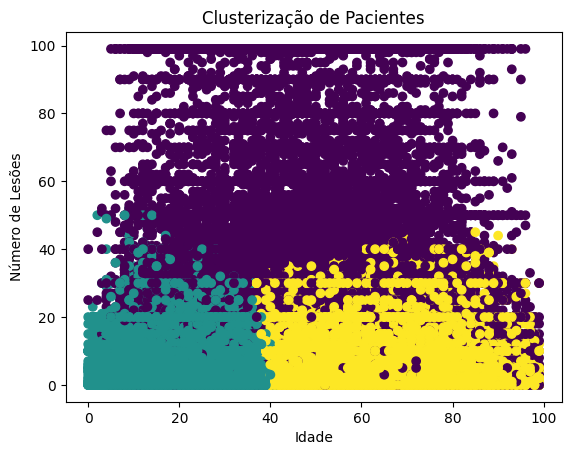

In [18]:
# Selecionando features numéricas para clusterização
features_cluster = ['NU_IDADE_N', 'NU_LESOES', 'DOSE_RECEB']

# Normalizando os dados
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[features_cluster])

# Aplicando K-means
kmeans = KMeans(n_clusters=3, random_state=42)
df['Cluster'] = kmeans.fit_predict(X_scaled)

# Visualizando os resultados
plt.scatter(df['NU_IDADE_N'], df['NU_LESOES'], c=df['Cluster'], cmap='viridis')
plt.xlabel('Idade')
plt.ylabel('Número de Lesões')
plt.title('Clusterização de Pacientes')
plt.show()



Cluster 0:
          NU_IDADE_N   CS_SEXO        CS_RACA      NU_LESOES     FORMACLINI  \
count  385576.000000  385576.0  385576.000000  385576.000000  385576.000000   
mean       46.282518       0.0       3.039424       9.064182       3.338514   
std        17.898451       0.0       1.678280      12.332878       0.725692   
min         0.000000       0.0       0.000000       0.000000       0.000000   
25%        33.000000       0.0       1.000000       2.000000       3.000000   
50%        47.000000       0.0       4.000000       6.000000       3.000000   
75%        59.000000       0.0       4.000000      10.000000       4.000000   
max        99.000000       0.0       9.000000      99.000000       9.000000   

            AVALIA_N     CLASSOPERA     NERVOSAFET     DOSE_RECEB  \
count  385576.000000  385576.000000  385576.000000  385576.000000   
mean        0.772304       1.985956       1.549513      11.461585   
std         0.939111       0.179699       2.574110       4.119116   


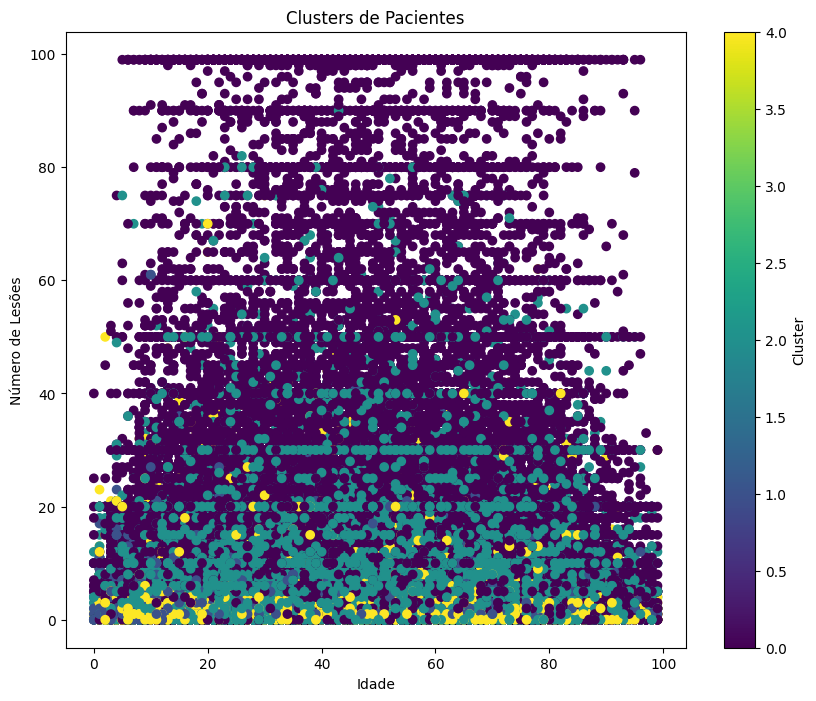

In [19]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

df = df_dados.copy()
# Selecionar as variáveis relevantes
features = ['NU_IDADE_N', 'CS_SEXO', 'CS_RACA', 'NU_LESOES', 'FORMACLINI', 
            'AVALIA_N', 'CLASSOPERA', 'NERVOSAFET', 'DOSE_RECEB', 'EPIS_RACIO']

# Preparar os dados
X = df[features]

# Converter variáveis categóricas em numéricas
# X = pd.get_dummies(X, columns=['CS_SEXO', 'CS_RACA', 'FORMACLINI', 'AVALIA_N', 'CLASSOPERA', 'EPIS_RACIO'])

# Normalizar os dados
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Aplicar K-means
kmeans = KMeans(n_clusters=5, random_state=42)
df['Cluster'] = kmeans.fit_predict(X_scaled)

# Analisar os clusters
for i in range(5):
    cluster_data = df[df['Cluster'] == i]
    print(f"\nCluster {i}:")
    print(cluster_data[features + ['TPALTA_N']].describe())

# Visualizar os clusters (exemplo com duas dimensões)
plt.figure(figsize=(10, 8))
plt.scatter(df['NU_IDADE_N'], df['NU_LESOES'], c=df['Cluster'], cmap='viridis')
plt.xlabel('Idade')
plt.ylabel('Número de Lesões')
plt.title('Clusters de Pacientes')
plt.colorbar(label='Cluster')
plt.show()


### PCA

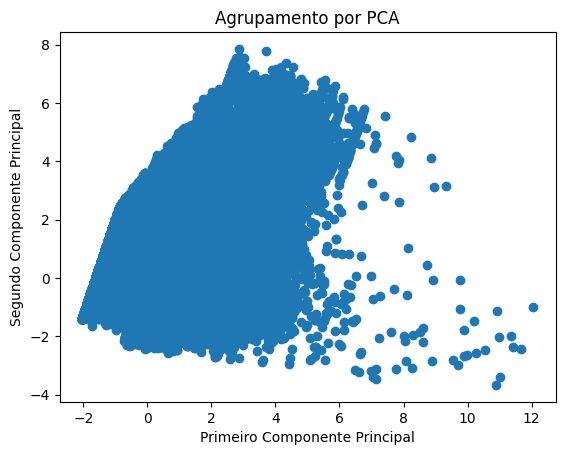

In [20]:
from sklearn.decomposition import PCA
df = df_dados.copy()
# Selecionando features numéricas para PCA
features_pca = ['NU_IDADE_N', 'NU_LESOES', 'DOSE_RECEB', 'EPIS_RACIO']

# Normalizando os dados
X_pca = StandardScaler().fit_transform(df[features_pca])

# Aplicando PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X_pca)

# Criando um DataFrame com os componentes principais
pca_df = pd.DataFrame(data = principalComponents, columns = ['PC1', 'PC2'])

# Visualizando os resultados
plt.scatter(pca_df['PC1'], pca_df['PC2'])
plt.xlabel('Primeiro Componente Principal')
plt.ylabel('Segundo Componente Principal')
plt.title('Agrupamento por PCA')
plt.show()


### Predição

In [21]:
# Selecionando features para predição
features_pred = ['NU_IDADE_N', 'NU_LESOES', 'DOSE_RECEB', 'EPIS_RACIO', 'FORMACLINI']
df = df_dados.copy()
# Preparando os dados
X = df[features_pred]
y = df['CLASSATUAL']

# Dividindo em conjunto de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Treinando o modelo
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Fazendo predições
y_pred = rf_model.predict(X_test)

# Avaliando o modelo
accuracy = accuracy_score(y_test, y_pred)
print(f'Acurácia do modelo: {accuracy:.2f}')

# Importância das features
importances = pd.DataFrame({'feature':features_pred, 'importance':rf_model.feature_importances_})
importances = importances.sort_values('importance', ascending=False)
print(importances)


Acurácia do modelo: 0.95
      feature  importance
4  FORMACLINI    0.595080
2  DOSE_RECEB    0.222878
1   NU_LESOES    0.135226
0  NU_IDADE_N    0.040813
3  EPIS_RACIO    0.006003


### Serie Temporal

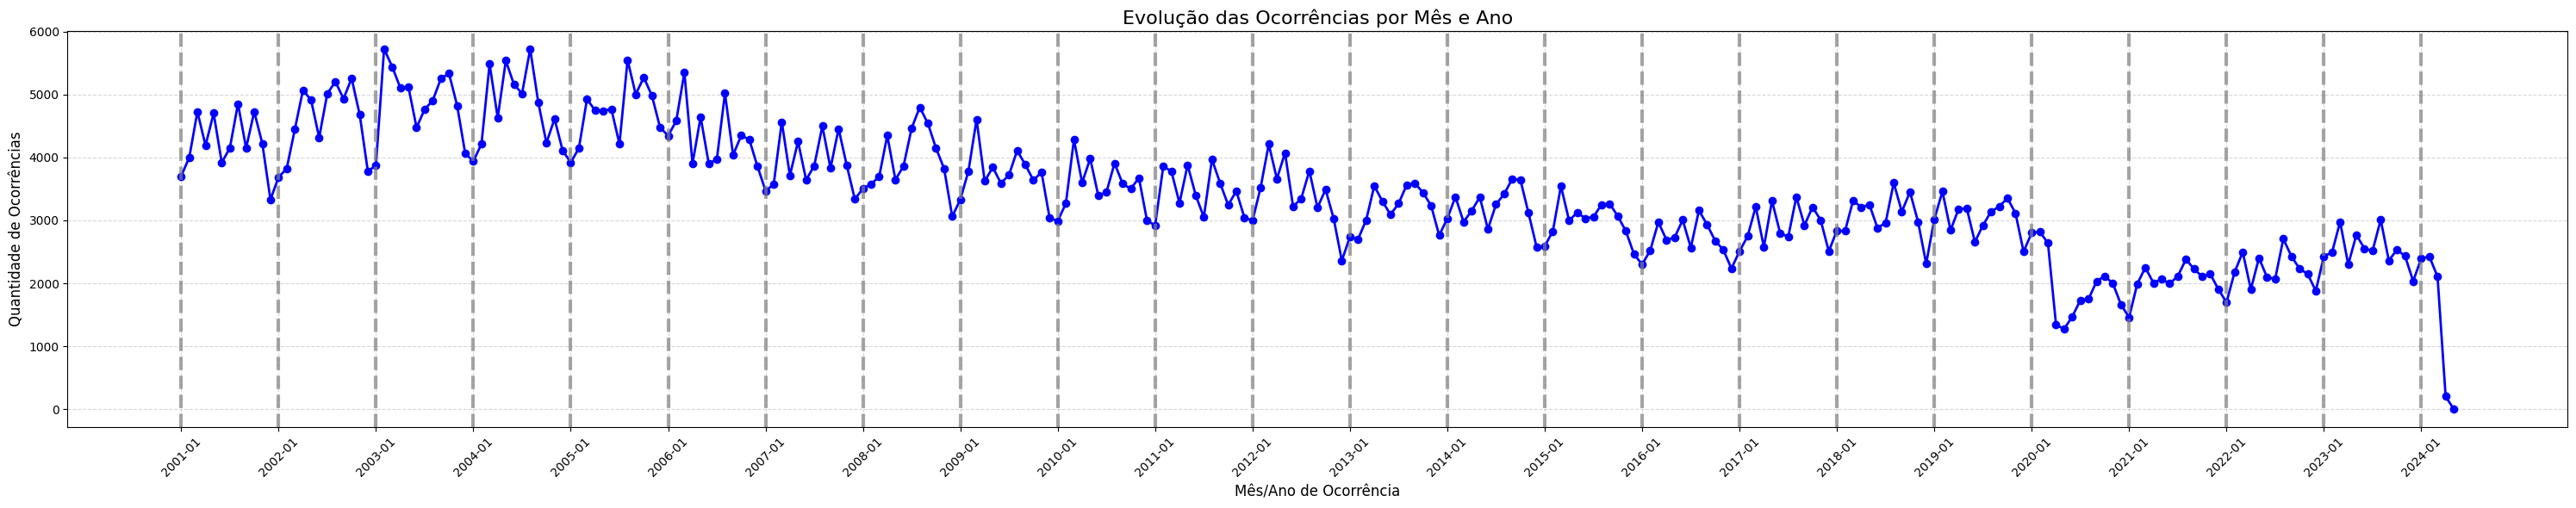

In [38]:
df = df_dados.copy()
# Converter a coluna DT_NOTIFIC para datetime
df["DT_NOTIFIC"] = pd.to_datetime(df["DT_NOTIFIC"], format='%Y%m%d', errors='coerce')

# Criar uma nova coluna no formato "AAAA-MM"
df["ANO_MES"] = df["DT_NOTIFIC"].dt.to_period("M").astype(str)

# Agrupar os dados por "ANO_MES" e contar a quantidade de ocorrências
dados_agrupados = df.groupby("ANO_MES").size().reset_index(name="quantidade")

# Detectar mudanças de ano para adicionar linhas verticais
dados_agrupados["ANO"] = dados_agrupados["ANO_MES"].str[:4]
anos_unicos = dados_agrupados["ANO"].drop_duplicates().index

# Plotar o gráfico de linha com todos os pontos
fig, ax = plt.subplots(figsize=(30, 6))

ax.plot(
    dados_agrupados["ANO_MES"],
    dados_agrupados["quantidade"],
    marker='o',
    linestyle='-',
    linewidth=2,
    color='b'
)

# Configurar título e rótulos dos eixos
ax.set_title("Evolução das Ocorrências por Mês e Ano", fontsize=16)
ax.set_xlabel("Mês/Ano de Ocorrência", fontsize=12)
ax.set_ylabel("Quantidade de Ocorrências", fontsize=12)

# Ajustar os ticks (marcadores) do eixo X para exibir de 6 em 6 meses (somente legenda)
xticks = dados_agrupados["ANO_MES"][::12]  # Seleciona a cada 6 meses
ax.set_xticks(xticks)
ax.set_xticklabels(xticks, rotation=45)

# Adicionar linhas verticais nos inícios de cada ano
for ano_idx in anos_unicos:
    ax.axvline(x=ano_idx, color='gray', linestyle='--', linewidth=3, alpha=0.7)

# Exibir grid para melhor visualização
plt.grid(True, linestyle='--', alpha=0.5)

# Ajustar a disposição do layout
plt.tight_layout()

# Exibir o gráfico
plt.show()



### Prophet (Predição)

1- Linha do tempo principal:
    - Eixo X: Data de notificação (DT_NOTIFIC)
    - Eixo Y: Número de casos notificados
2- Pontos sobrepostos à linha do tempo:
    - Cada ponto representa um caso individual
    - Tamanho do ponto: Número de lesões cutâneas (NU_LESOES)
    - Cor do ponto: Forma clínica (FORMACLINI)
3- Barras empilhadas abaixo da linha principal:
    - Representando a distribuição de classificação operacional (CLASSOPERA)
4- Linha secundária:
    - Mostrando a média móvel de doses recebidas (DOSE_RECEB)
5- Área sombreada:
    - Indicando o número de contatos examinados (CONTEXAM)

c:\Users\aureziano\Desktop\Codigos\python\mestrado\data_health\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
15:42:50 - cmdstanpy - INFO - Chain [1] start processing
15:42:51 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\aureziano\Desktop\Codigos\python\mestrado\data_health\.venv\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


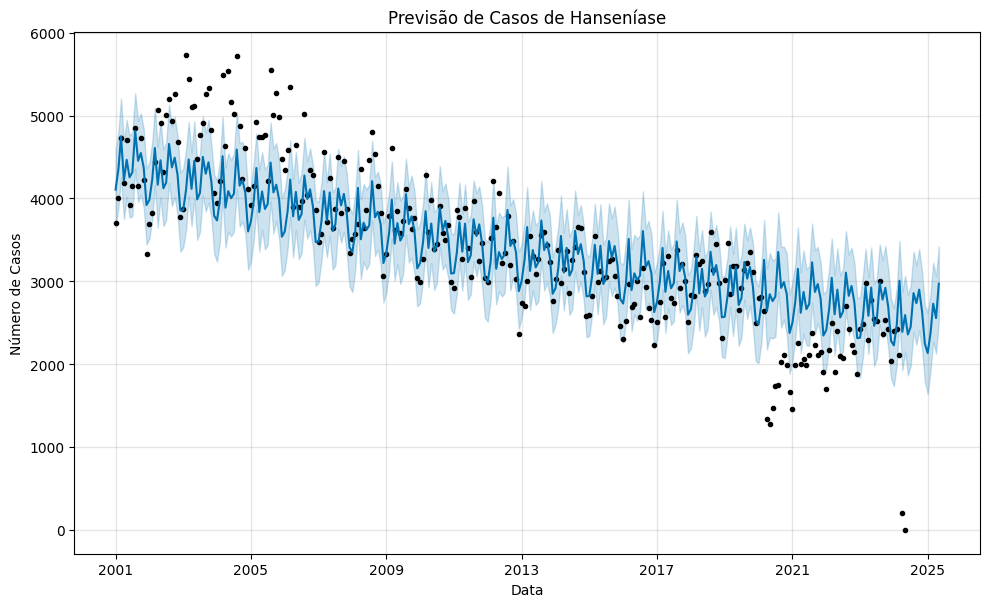

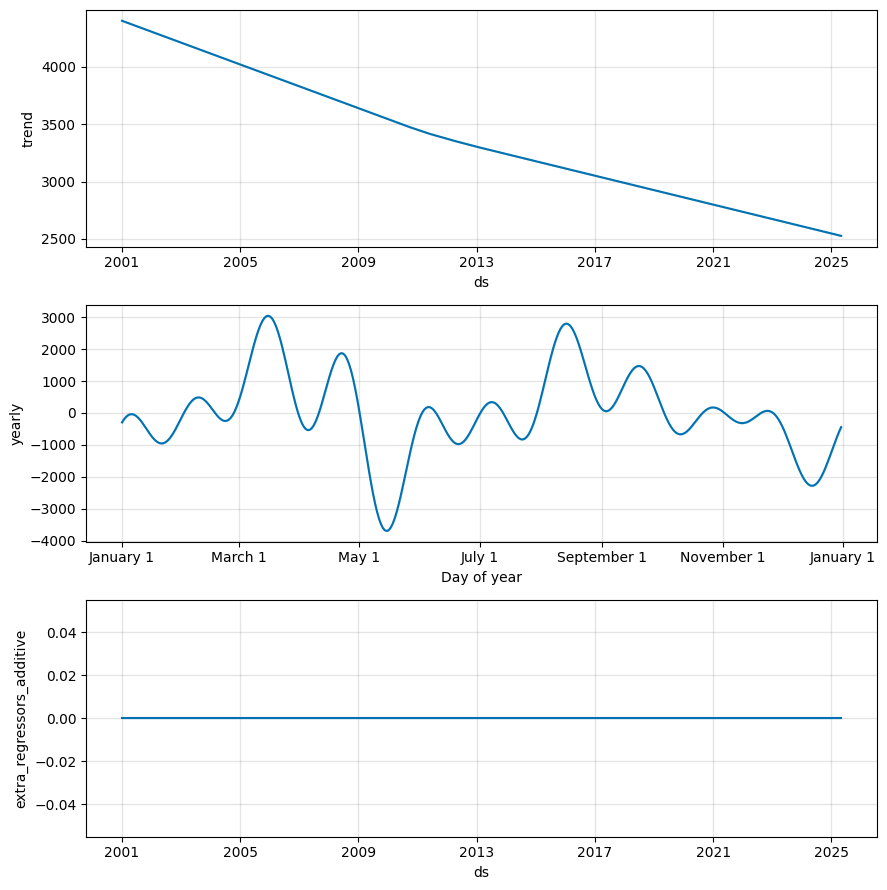

In [22]:
import pandas as pd
import numpy as np
from prophet import Prophet
import matplotlib.pyplot as plt
df = df_dados.copy()
# Converter a coluna DT_NOTIFIC para datetime
df['DT_NOTIFIC'] = pd.to_datetime(df['DT_NOTIFIC'], format='%Y%m%d', errors='coerce')

# Criar uma nova coluna no formato "AAAA-MM"
df['ANO_MES'] = df['DT_NOTIFIC'].dt.to_period('M').astype(str)

# Agrupar os dados por "ANO_MES" e calcular as médias e contagens necessárias
df_prophet = df.groupby('ANO_MES').agg({
    'NU_IDADE_N': 'mean',
    'NU_LESOES': 'mean',
    'NERVOSAFET': 'mean',
    'DOSE_RECEB': 'mean',
    'ID_MUNICIP': 'count'  # Contagem de casos
}).reset_index()

# Renomear as colunas conforme exigido pelo Prophet
df_prophet = df_prophet.rename(columns={
    'ANO_MES': 'ds',
    'ID_MUNICIP': 'y',
    'NU_IDADE_N': 'idade_media',
    'NU_LESOES': 'lesoes_media',
    'NERVOSAFET': 'nervos_afetados_media',
    'DOSE_RECEB': 'doses_recebidas_media'
})

# Converter a coluna 'ds' para datetime
df_prophet['ds'] = pd.to_datetime(df_prophet['ds'])

# Criar e treinar o modelo
model = Prophet()
model.add_regressor('idade_media')
model.add_regressor('lesoes_media')
model.add_regressor('nervos_afetados_media')
model.add_regressor('doses_recebidas_media')

model.fit(df_prophet)

# Criar dataframe para previsão futura
future_dates = model.make_future_dataframe(periods=12, freq='M')  # Prever próximos 12 meses
future_dates['idade_media'] = df_prophet['idade_media'].mean()
future_dates['lesoes_media'] = df_prophet['lesoes_media'].mean()
future_dates['nervos_afetados_media'] = df_prophet['nervos_afetados_media'].mean()
future_dates['doses_recebidas_media'] = df_prophet['doses_recebidas_media'].mean()

# Fazer previsões
forecast = model.predict(future_dates)

# Plotar resultados
fig = model.plot(forecast)
plt.title('Previsão de Casos de Hanseníase')
plt.xlabel('Data')
plt.ylabel('Número de Casos')
plt.show()

# Plotar componentes da previsão
fig2 = model.plot_components(forecast)
plt.show()


#### Prophet - Grafico interativo

16:11:32 - cmdstanpy - INFO - Chain [1] start processing
16:11:33 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\aureziano\Desktop\Codigos\python\mestrado\data_health\.venv\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.



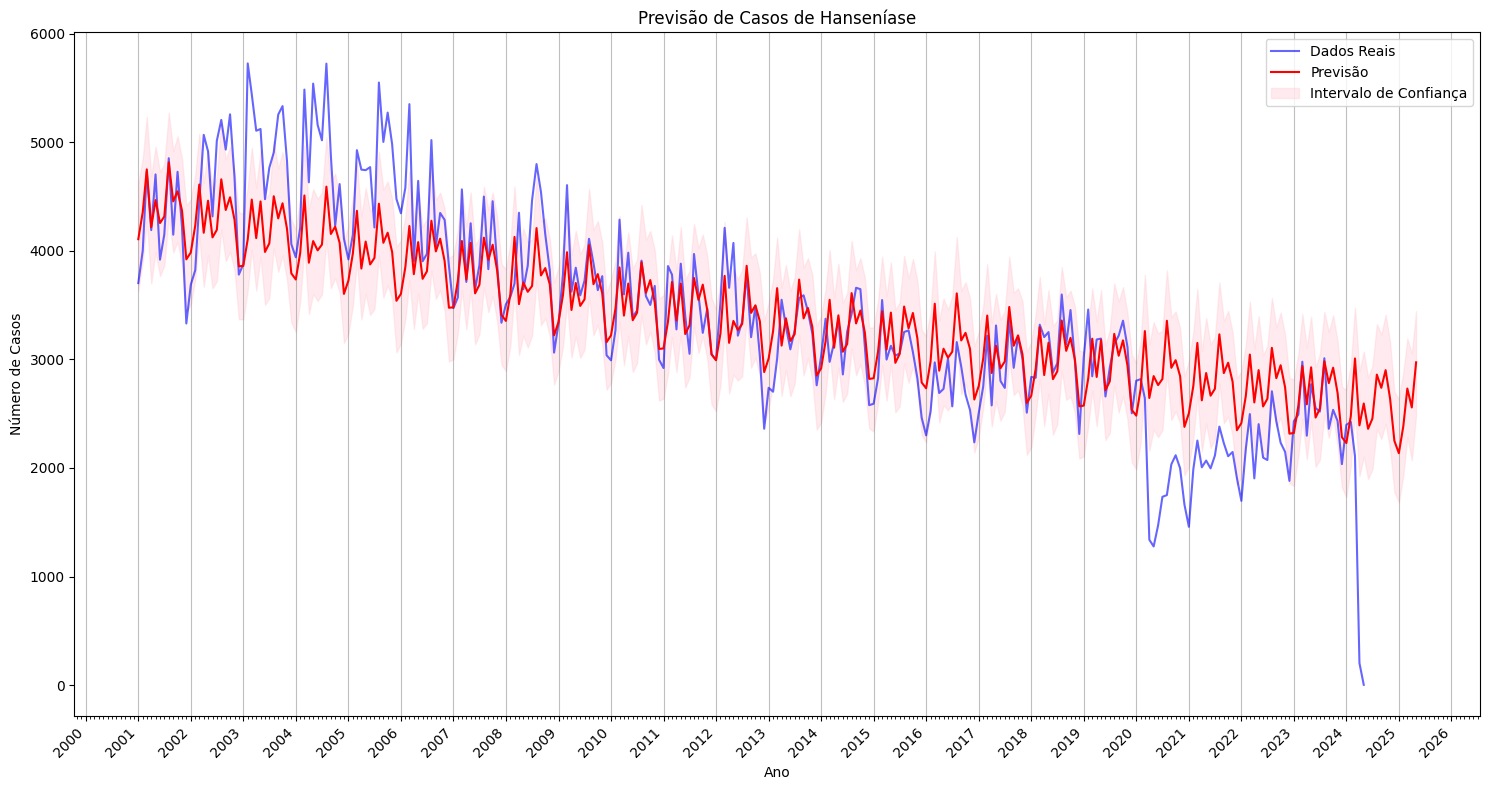

In [32]:
import pandas as pd
import numpy as np
from prophet import Prophet
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Assumindo que df_dados já está carregado
df = df_dados.copy()

# Converter a coluna DT_NOTIFIC para datetime
df['DT_NOTIFIC'] = pd.to_datetime(df['DT_NOTIFIC'], format='%Y%m%d', errors='coerce')

# Criar uma nova coluna no formato "AAAA-MM"
df['ANO_MES'] = df['DT_NOTIFIC'].dt.to_period('M').astype(str)

# Agrupar os dados por "ANO_MES" e calcular as médias e contagens necessárias
df_prophet = df.groupby('ANO_MES').agg({
    'NU_IDADE_N': 'mean',
    'NU_LESOES': 'mean',
    'NERVOSAFET': 'mean',
    'DOSE_RECEB': 'mean',
    'ID_MUNICIP': 'count'  # Contagem de casos
}).reset_index()

# Renomear as colunas conforme exigido pelo Prophet
df_prophet = df_prophet.rename(columns={
    'ANO_MES': 'ds',
    'ID_MUNICIP': 'y',
    'NU_IDADE_N': 'idade_media',
    'NU_LESOES': 'lesoes_media',
    'NERVOSAFET': 'nervos_afetados_media',
    'DOSE_RECEB': 'doses_recebidas_media'
})

# Converter a coluna 'ds' para datetime
df_prophet['ds'] = pd.to_datetime(df_prophet['ds'])

# Criar e treinar o modelo
model = Prophet()
model.add_regressor('idade_media')
model.add_regressor('lesoes_media')
model.add_regressor('nervos_afetados_media')
model.add_regressor('doses_recebidas_media')

model.fit(df_prophet)

# Criar dataframe para previsão futura
future_dates = model.make_future_dataframe(periods=12, freq='M')  # Prever próximos 12 meses
future_dates['idade_media'] = df_prophet['idade_media'].mean()
future_dates['lesoes_media'] = df_prophet['lesoes_media'].mean()
future_dates['nervos_afetados_media'] = df_prophet['nervos_afetados_media'].mean()
future_dates['doses_recebidas_media'] = df_prophet['doses_recebidas_media'].mean()

# Fazer previsões
forecast = model.predict(future_dates)

# Configurar o gráfico
fig, ax = plt.subplots(figsize=(15, 8))

# Plotar dados reais
ax.plot(df_prophet['ds'], df_prophet['y'], color='blue', label='Dados Reais', alpha=0.6)

# Plotar previsão
ax.plot(forecast['ds'], forecast['yhat'], color='red', label='Previsão')

# Adicionar intervalo de confiança
ax.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='pink', alpha=0.3, label='Intervalo de Confiança')

# Configurar eixo x
years = mdates.YearLocator()
months = mdates.MonthLocator()
years_fmt = mdates.DateFormatter('%Y')

ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(years_fmt)
ax.xaxis.set_minor_locator(months)

# Adicionar linhas de grade para cada ano
ax.grid(which='major', axis='x', linestyle='-', color='gray', alpha=0.5)

# Configurar labels e título
ax.set_xlabel('Ano')
ax.set_ylabel('Número de Casos')
ax.set_title('Previsão de Casos de Hanseníase')

# Adicionar legenda
ax.legend()

# Rotacionar labels do eixo x para melhor visualização
plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')

# Ajustar o layout
plt.tight_layout()

# Mostrar o gráfico
plt.show()


### Uso de Redes neurais

Epoch 1/100


c:\Users\aureziano\Desktop\Codigos\python\mestrado\data_health\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - loss: 0.4603 - val_loss: 0.1285
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2275 - val_loss: 0.0028
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0738 - val_loss: 0.1618
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0804 - val_loss: 0.0904
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0370 - val_loss: 0.0066
Epoch 6/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0159 - val_loss: 0.0028
Epoch 7/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0077 - val_loss: 0.0027
Epoch 8/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0101 - val_loss: 0.0038
Epoch 9/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0101 - val_loss: 0.0031
Epoch 10/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0086 - val_loss: 0.0035
Epoch 11/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0078 - val_loss: 0.0048
Epoch 12/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0075 - val_loss: 0.0028
E

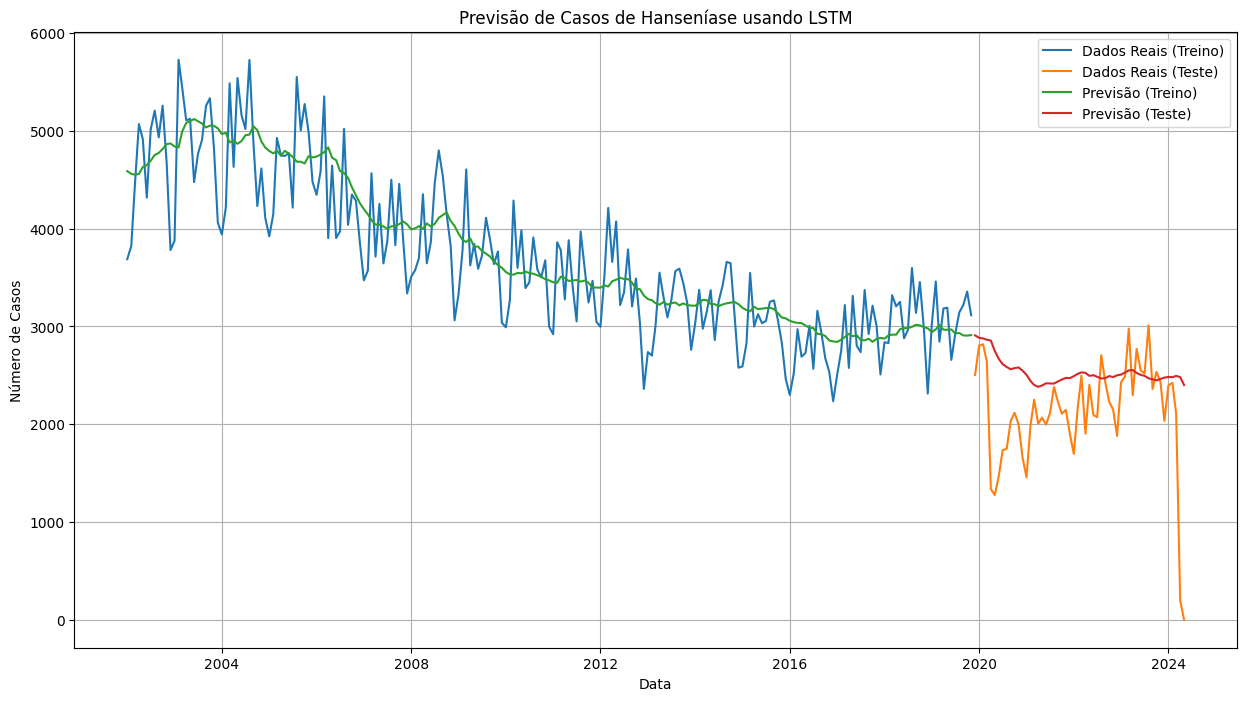

In [35]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt

# Assumindo que df_prophet já está preparado como no exemplo anterior

# Preparar os dados
data = df_prophet[['ds', 'y', 'idade_media', 'lesoes_media', 'nervos_afetados_media', 'doses_recebidas_media']].set_index('ds')

# Normalizar os dados
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Preparar sequências de entrada e saída
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:(i + seq_length), :])
        y.append(data[i + seq_length, 0])
    return np.array(X), np.array(y)

seq_length = 12  # Usar 12 meses de histórico para prever o próximo mês
X, y = create_sequences(scaled_data, seq_length)

# Dividir em conjuntos de treino e teste
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Criar e treinar o modelo LSTM
model = Sequential([
    LSTM(50, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')
model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.1, verbose=1)

# Fazer previsões
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Inverter a normalização
train_predict = scaler.inverse_transform(np.column_stack((train_predict, np.zeros((len(train_predict), 4)))))[:, 0]
test_predict = scaler.inverse_transform(np.column_stack((test_predict, np.zeros((len(test_predict), 4)))))[:, 0]
y_train = scaler.inverse_transform(np.column_stack((y_train.reshape(-1, 1), np.zeros((len(y_train), 4)))))[:, 0]
y_test = scaler.inverse_transform(np.column_stack((y_test.reshape(-1, 1), np.zeros((len(y_test), 4)))))[:, 0]

# Plotar resultados
plt.figure(figsize=(15, 8))
plt.plot(data.index[seq_length:train_size+seq_length], y_train, label='Dados Reais (Treino)')
plt.plot(data.index[train_size+seq_length:], y_test, label='Dados Reais (Teste)')
plt.plot(data.index[seq_length:train_size+seq_length], train_predict, label='Previsão (Treino)')
plt.plot(data.index[train_size+seq_length:], test_predict, label='Previsão (Teste)')
plt.title('Previsão de Casos de Hanseníase usando LSTM')
plt.xlabel('Data')
plt.ylabel('Número de Casos')
plt.legend()
plt.grid(True)
plt.show()


### ARIMA

c:\Users\aureziano\Desktop\Codigos\python\mestrado\data_health\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

c:\Users\aureziano\Desktop\Codigos\python\mestrado\data_health\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

c:\Users\aureziano\Desktop\Codigos\python\mestrado\data_health\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



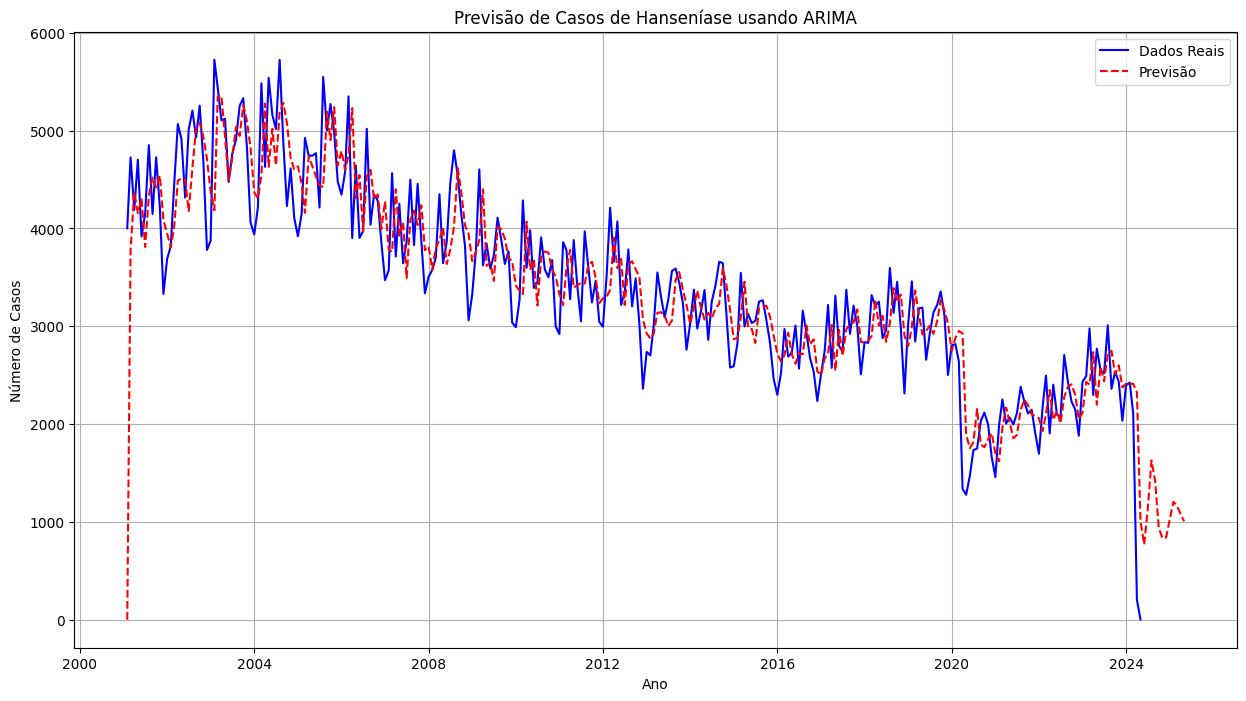

In [57]:
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt

# Preparar os dados
df_arima = df_prophet[['ds', 'y']].set_index('ds')

# Ajustar o modelo ARIMA
model_arima = ARIMA(df_arima, order=(5, 1, 0))  # Parâmetros (p, d, q)
model_arima_fit = model_arima.fit()

# Fazer previsões para todo o período
forecast_arima = model_arima_fit.predict(start=0, end=len(df_arima) + 11)  # Prever até 12 passos à frente

# Plotar resultados
plt.figure(figsize=(15, 8))
plt.plot(df_arima.index, df_arima['y'], label='Dados Reais', color='blue')
plt.plot(forecast_arima.index, forecast_arima.values, label='Previsão', linestyle='--', color='red')
plt.title('Previsão de Casos de Hanseníase usando ARIMA')
plt.xlabel('Ano')
plt.ylabel('Número de Casos')
plt.legend()
plt.grid(True)
plt.show()


### SARIMA 

c:\Users\aureziano\Desktop\Codigos\python\mestrado\data_health\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

c:\Users\aureziano\Desktop\Codigos\python\mestrado\data_health\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



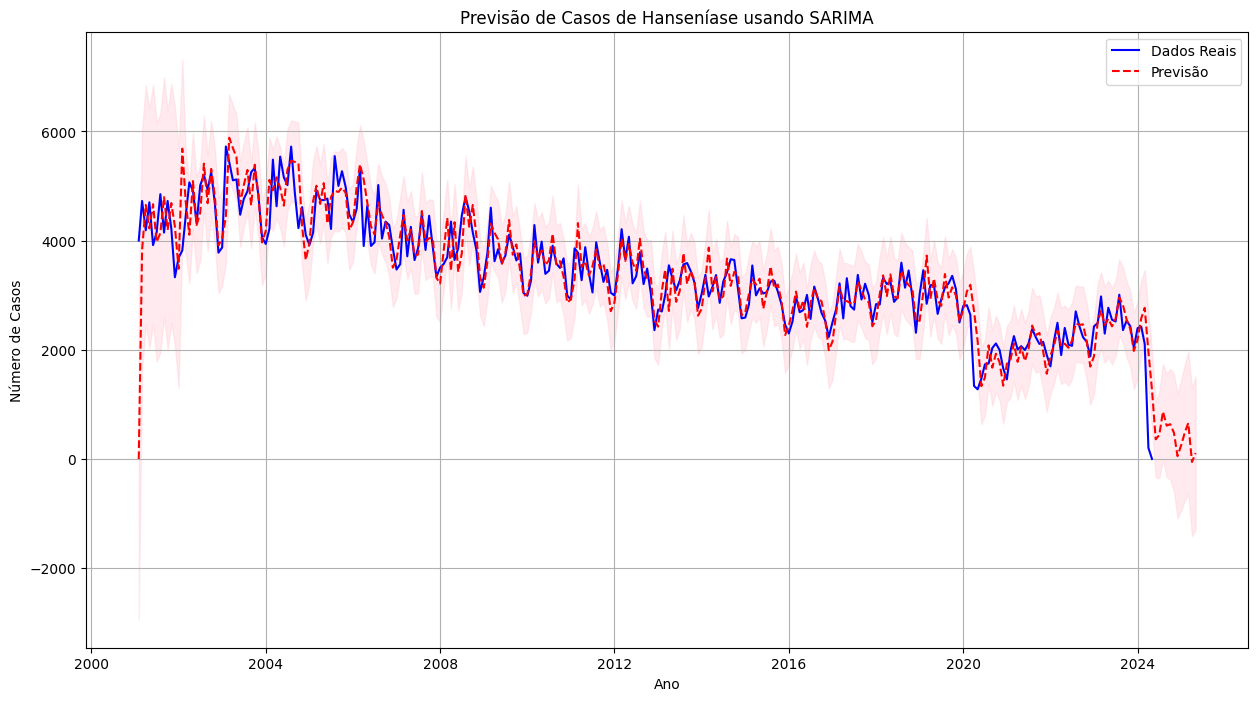

In [58]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt

# Ajustar o modelo SARIMA
model_sarima = SARIMAX(df_arima['y'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
model_sarima_fit = model_sarima.fit()

# Fazer previsões para todo o período
forecast_sarima = model_sarima_fit.get_prediction(start=0, end=len(df_arima) + 11)
forecast_sarima_mean = forecast_sarima.predicted_mean
forecast_sarima_ci = forecast_sarima.conf_int()

# Plotar resultados
plt.figure(figsize=(15, 8))
plt.plot(df_arima.index, df_arima['y'], label='Dados Reais', color='blue')
plt.plot(forecast_sarima_mean.index, forecast_sarima_mean.values, label='Previsão', linestyle='--', color='red')
plt.fill_between(forecast_sarima_ci.index,
                 forecast_sarima_ci.iloc[:, 0],
                 forecast_sarima_ci.iloc[:, 1], color='pink', alpha=0.3)
plt.title('Previsão de Casos de Hanseníase usando SARIMA')
plt.xlabel('Ano')
plt.ylabel('Número de Casos')
plt.legend()
plt.grid(True)
plt.show()


### XGBoost ou LightGBM

In [59]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Criar variável lag_1 (valor anterior como feature)
df_prophet['lag_1'] = df_prophet['y'].shift(1)
df_prophet.dropna(inplace=True)

# Dividir em treino e teste
X = df_prophet[['lag_1']]
y = df_prophet['y']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Treinar o modelo XGBoost
model_xgb = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100)
model_xgb.fit(X_train, y_train)

# Prever todo o período histórico e futuro (12 passos à frente)
df_prophet['Previsão'] = np.nan
for i in range(len(df_prophet)):
    if i == 0:
        continue
    df_prophet.loc[i, 'Previsão'] = model_xgb.predict([[df_prophet.loc[i - 1, 'y']]])

# Adicionar previsões futuras (12 passos à frente)
for i in range(12):
    last_value = df_prophet.iloc[-1]['Previsão']
    new_row = {'ds': df_prophet.iloc[-1]['ds'] + pd.DateOffset(months=1),
               'lag_1': last_value,
               'Previsão': model_xgb.predict([[last_value]])[0]}
    df_prophet = pd.concat([df_prophet, pd.DataFrame([new_row])], ignore_index=True)

# Plotar resultados
plt.figure(figsize=(15, 8))
plt.plot(df_prophet['ds'], df_prophet['y'], label='Dados Reais', color='blue')
plt.plot(df_prophet['ds'], df_prophet['Previsão'], label='Previsão', linestyle='--', color='red')
plt.title('Previsão de Casos de Hanseníase usando XGBoost')
plt.xlabel('Ano')
plt.ylabel('Número de Casos')
plt.legend()
plt.grid(True)
plt.show()


KeyError: 0

Modelo	Melhor Para	Limitações
Prophet	Sazonalidade e tendência simples	Não lida bem com padrões não-lineares complexos
ARIMA	Séries temporais lineares	Não lida bem com sazonalidade
SARIMA	Séries sazonais	Complexidade na escolha dos parâmetros
LSTM	Padrões não-lineares complexos	Exige mais dados e tempo
XGBoost	Séries supervisionadas	Não captura dependências temporais diretamente

### Usando pytoch

Usando dispositivo: cuda
Época [10/200], Perda Treino: 0.0071, Perda Teste: 0.0108
Época [20/200], Perda Treino: 0.0062, Perda Teste: 0.0092
Época [30/200], Perda Treino: 0.0068, Perda Teste: 0.0110
Época [40/200], Perda Treino: 0.0066, Perda Teste: 0.0090
Época [50/200], Perda Treino: 0.0075, Perda Teste: 0.0088
Época [60/200], Perda Treino: 0.0061, Perda Teste: 0.0087
Época [70/200], Perda Treino: 0.0064, Perda Teste: 0.0092
Época [80/200], Perda Treino: 0.0059, Perda Teste: 0.0088
Época [90/200], Perda Treino: 0.0060, Perda Teste: 0.0096
Época [100/200], Perda Treino: 0.0065, Perda Teste: 0.0091
Época [110/200], Perda Treino: 0.0072, Perda Teste: 0.0104
Época [120/200], Perda Treino: 0.0066, Perda Teste: 0.0083
Época [130/200], Perda Treino: 0.0059, Perda Teste: 0.0084
Época [140/200], Perda Treino: 0.0064, Perda Teste: 0.0085
Época [150/200], Perda Treino: 0.0065, Perda Teste: 0.0082
Época [160/200], Perda Treino: 0.0064, Perda Teste: 0.0076
Época [170/200], Perda Treino: 0.0061, P

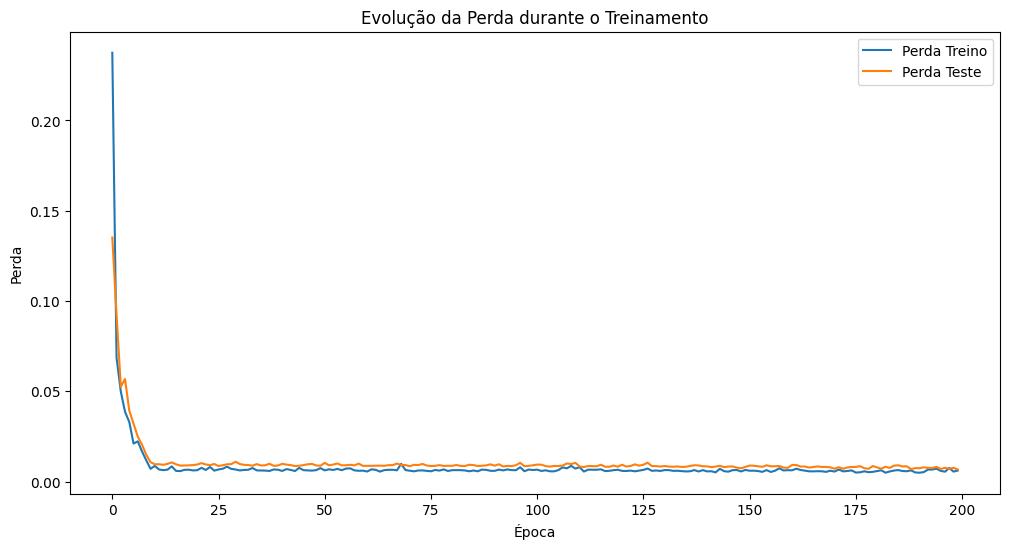

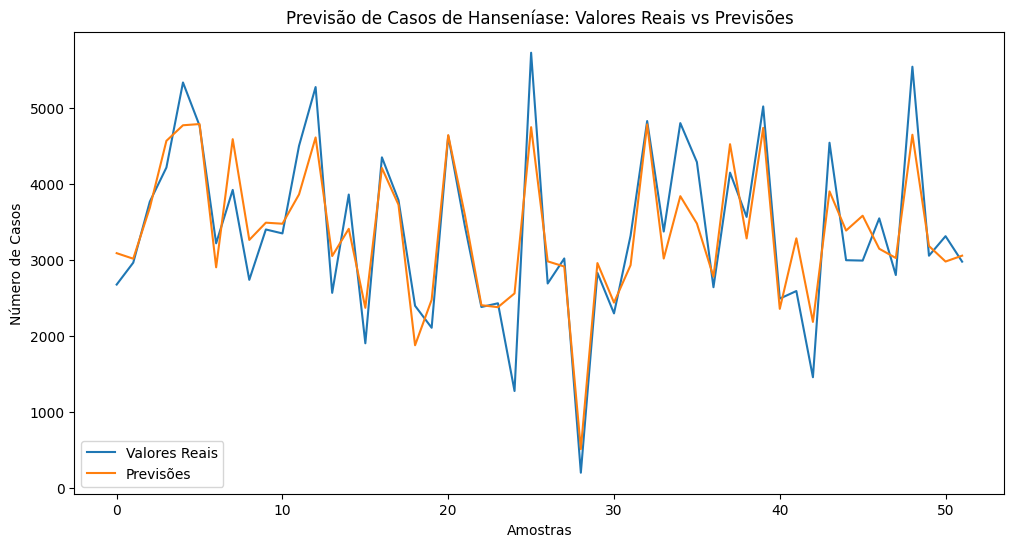

MSE: 221056.0881
RMSE: 470.1660
MAE: 371.5759


In [36]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt

# Verificar se CUDA está disponível
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Usando dispositivo: {device}")

# Preparar os dados
df_prophet = df_prophet.sort_values('ds')
data = df_prophet[['y', 'idade_media', 'lesoes_media', 'nervos_afetados_media', 'doses_recebidas_media']].values

# Normalizar os dados
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Preparar sequências de entrada e saída
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:(i + seq_length), :])
        y.append(data[i + seq_length, 0])
    return np.array(X), np.array(y)

seq_length = 24  # Aumentado para capturar mais contexto temporal
X, y = create_sequences(scaled_data, seq_length)

# Dividir em conjuntos de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Converter para tensores PyTorch
X_train = torch.FloatTensor(X_train).to(device)
y_train = torch.FloatTensor(y_train).to(device)
X_test = torch.FloatTensor(X_test).to(device)
y_test = torch.FloatTensor(y_test).to(device)

# Criar DataLoaders
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Definir modelo LSTM
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=0.2)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

# Hiperparâmetros
input_size = 5
hidden_size = 128
num_layers = 2
output_size = 1
num_epochs = 200
learning_rate = 0.001

# Inicializar modelo
model = LSTM(input_size, hidden_size, num_layers, output_size).to(device)

# Definir função de perda e otimizador
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Treinar o modelo
train_losses = []
test_losses = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs.squeeze(), batch_y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            outputs = model(batch_X)
            loss = criterion(outputs.squeeze(), batch_y)
            test_loss += loss.item()
    
    train_losses.append(train_loss / len(train_loader))
    test_losses.append(test_loss / len(test_loader))
    
    if (epoch + 1) % 10 == 0:
        print(f'Época [{epoch+1}/{num_epochs}], Perda Treino: {train_losses[-1]:.4f}, Perda Teste: {test_losses[-1]:.4f}')

# Plotar resultados
plt.figure(figsize=(12, 6))
plt.plot(train_losses, label='Perda Treino')
plt.plot(test_losses, label='Perda Teste')
plt.xlabel('Época')
plt.ylabel('Perda')
plt.title('Evolução da Perda durante o Treinamento')
plt.legend()
plt.show()

# Fazer previsões
model.eval()
with torch.no_grad():
    test_predictions = model(X_test).cpu().numpy()

# Inverter a normalização
test_predictions = scaler.inverse_transform(np.column_stack((test_predictions, np.zeros((len(test_predictions), 4)))))[:, 0]
y_test_actual = scaler.inverse_transform(np.column_stack((y_test.cpu().numpy().reshape(-1, 1), np.zeros((len(y_test), 4)))))[:, 0]

# Plotar previsões vs valores reais
plt.figure(figsize=(12, 6))
plt.plot(y_test_actual, label='Valores Reais')
plt.plot(test_predictions, label='Previsões')
plt.xlabel('Amostras')
plt.ylabel('Número de Casos')
plt.title('Previsão de Casos de Hanseníase: Valores Reais vs Previsões')
plt.legend()
plt.show()

# Calcular métricas de desempenho
mse = np.mean((y_test_actual - test_predictions)**2)
rmse = np.sqrt(mse)
mae = np.mean(np.abs(y_test_actual - test_predictions))
print(f'MSE: {mse:.4f}')
print(f'RMSE: {rmse:.4f}')
print(f'MAE: {mae:.4f}')


### Toch versao 2

### Grafico

Usando dispositivo: cuda
Época [20/200], Perda Treino: 0.0364, Perda Validação: 0.0262
Época [40/200], Perda Treino: 0.0189, Perda Validação: 0.0517
Época [60/200], Perda Treino: 0.0159, Perda Validação: 0.0595
Época [80/200], Perda Treino: 0.0134, Perda Validação: 0.0569
Época [100/200], Perda Treino: 0.0067, Perda Validação: 0.0192
Época [120/200], Perda Treino: 0.0065, Perda Validação: 0.0191
Época [140/200], Perda Treino: 0.0063, Perda Validação: 0.0149
Época [160/200], Perda Treino: 0.0062, Perda Validação: 0.0150
Época [180/200], Perda Treino: 0.0062, Perda Validação: 0.0149
Época [200/200], Perda Treino: 0.0061, Perda Validação: 0.0145


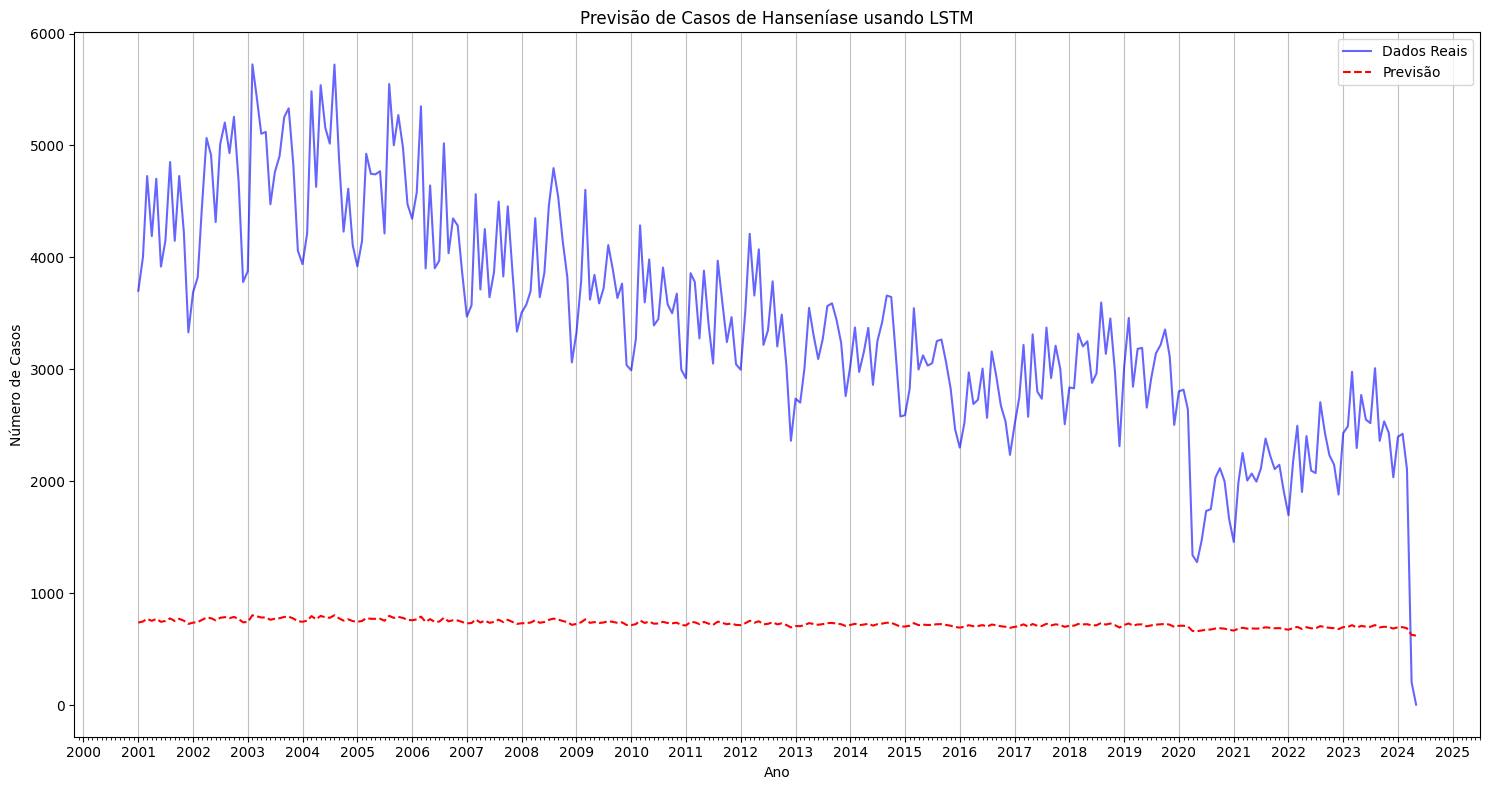

In [51]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Verificar se CUDA está disponível
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Usando dispositivo: {device}")

# Preparar os dados
df = df_dados.copy()
df['DT_NOTIFIC'] = pd.to_datetime(df['DT_NOTIFIC'], format='%Y%m%d', errors='coerce')

# Agrupar por mês
df['ANO_MES'] = df['DT_NOTIFIC'].dt.to_period('M').astype(str)
df_mensal = df.groupby('ANO_MES').size().reset_index(name='casos')
df_mensal['ANO_MES'] = pd.to_datetime(df_mensal['ANO_MES'])

# Preparar dados para o modelo
data = df_mensal[['casos']].values
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Preparar sequências
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:(i + seq_length), 0])
        y.append(data[i + seq_length, 0])
    return np.array(X), np.array(y)

seq_length = 12  # 12 meses (1 ano)
X, y = create_sequences(scaled_data, seq_length)

# Dividir em treino e teste (80% treino, 20% teste)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Converter para tensores PyTorch
X_train_tensor = torch.FloatTensor(X_train).unsqueeze(2).to(device)
y_train_tensor = torch.FloatTensor(y_train).to(device)
X_test_tensor = torch.FloatTensor(X_test).unsqueeze(2).to(device)
y_test_tensor = torch.FloatTensor(y_test).to(device)

# Definir modelo LSTM com parâmetros ajustáveis
class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_size=128, num_layers=2, output_size=1):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

# Inicializar o modelo LSTM com hiperparâmetros ajustados
hidden_size = 128  # Número de neurônios na camada oculta
num_layers = 2     # Número de camadas LSTM
learning_rate = 0.001  # Taxa de aprendizado

model = LSTM(input_size=1, hidden_size=hidden_size, num_layers=num_layers).to(device)

# Definir função de perda e otimizador
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Treinar o modelo
num_epochs = 200  # Número de épocas para treinamento

train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs.squeeze(), y_train_tensor)
    loss.backward()
    optimizer.step()
    
    train_losses.append(loss.item())
    
    # Avaliar no conjunto de teste
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_test_tensor)
        val_loss = criterion(val_outputs.squeeze(), y_test_tensor)
        val_losses.append(val_loss.item())
    
    if (epoch + 1) % 20 == 0:
        print(f'Época [{epoch+1}/{num_epochs}], Perda Treino: {loss.item():.4f}, Perda Validação: {val_loss.item():.4f}')

# Fazer previsões para todo o conjunto de dados (treino + teste)
model.eval()
with torch.no_grad():
    all_data_tensor = torch.FloatTensor(scaled_data).unsqueeze(2).to(device)
    predictions_scaled = model(all_data_tensor).cpu().numpy()

# Inverter a normalização das previsões e dos dados reais
predictions_inverted = scaler.inverse_transform(predictions_scaled.reshape(-1, 1))
real_values_inverted = scaler.inverse_transform(scaled_data)

# Configurar o gráfico para visualização final
fig, ax = plt.subplots(figsize=(15, 8))

# Plotar dados reais (linha azul sólida)
ax.plot(df_mensal['ANO_MES'], real_values_inverted.flatten(), color='blue', label='Dados Reais', alpha=0.6)

# Plotar previsões (linha vermelha tracejada)
ax.plot(df_mensal['ANO_MES'], predictions_inverted.flatten(), color='red', linestyle='--', label='Previsão')

# Configurar eixo x com anos e meses formatados adequadamente
years_locator = mdates.YearLocator()
months_locator = mdates.MonthLocator()
years_fmt = mdates.DateFormatter('%Y')

ax.xaxis.set_major_locator(years_locator)
ax.xaxis.set_minor_locator(months_locator)
ax.xaxis.set_major_formatter(years_fmt)

# Adicionar grade e rótulos ao gráfico
ax.grid(which='major', axis='x', linestyle='-', color='gray', alpha=0.5)
ax.set_xlabel('Ano')
ax.set_ylabel('Número de Casos')
ax.set_title('Previsão de Casos de Hanseníase usando LSTM')
ax.legend()

plt.tight_layout()
plt.show()
